# TSP usando Concorde y Lin-Kernighan

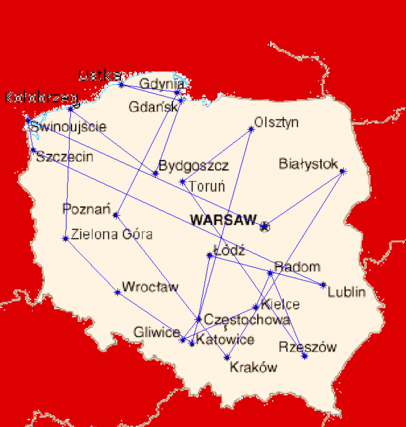

**Grupo 1 --> José María Amusquívar Poppe, Prashant Jeswani Tejwani

**INTRODUCCIÓN**

El kernel de este notebook es una copia del notebook: https://www.kaggle.com/wcukierski/concorde-solver, esto es debido a
que este kernel ya tenía installado el resolutor de "Concorde" en él, por lo que ya estaba preparado. 

La librería utilizada para resolver este problema se encuentra en: https://github.com/jvkersch/pyconcorde, ésta tiene las
dependencias de tener instalado tanto "Concorde" como "QSOpt". 

El resolutor "Concorde" puede ser encontrado en su página oficial: http://www.math.uwaterloo.ca/tsp/concorde.html, al igual
que "QSopt": https://www.math.uwaterloo.ca/~bico/qsopt/.

Una vez se tiene instalado y preparado todos estos paquetes, se puede emplear la librería "concorde.tsp" (indicado arriba), que
es capaz de unificar y facilitar el acceso al resolutor instalado.

Este problema será resuelto, además de usar estos resolutores, utilizando una de las mejores heurísticas, "Lin-Kernighan", para
conseguir esto se emplea un servidor web que ya tiene implementado esta hurística: https://neos-server.org/neos/solvers/co:concorde/TSP.html

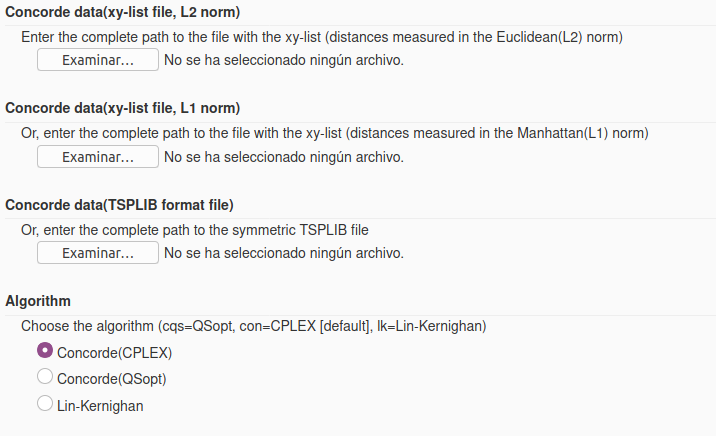

Este problema se divide atendiendo a si alguna coordenada del fichero es decimal o no, el motivo se explica en el método "solve_it()". 
La heurística se usará para algunos de estos ficheros, pero, a diferencia del resolutor "Concorde", no asegura óptimos.

In [ ]:
from concorde.tsp import TSPSolver
import os
from collections import namedtuple
import pandas as pd
import math
import numpy as np
import csv
from IPython.display import FileLink
import subprocess

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input/input-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
Point = namedtuple("Point", ['x', 'y'])

In [ ]:
def submission_generation(filename, str_output):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for item in str_output:
            writer.writerow(item)
    return FileLink(filename)

**MIDIENDO LAS DISTANCIAS**

Para el cálculo de las distancias, se emplea la distancia euclídeana aplicando su respectiva ecuación.

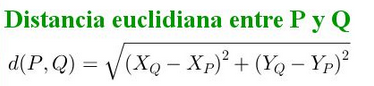

In [ ]:
def length(point1, point2):
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

**COMPROBANDO LA SOLUCIÓN**

Cuando se haya obtenido un resultado, será la hora de comprobar si éste es correcto o no, para este
cometido se emplea este método que, además de comprobar si es correcto, devuelve la distancia total
recorrida.

En el formato que se eligió, el vector de solución debe tener como primer elemento y último elemento
la misma ciudad, puesto que se empieza en una y se termina el recorrido en la misma. Así que, la 
primera comprobación a realizar es si estos dos elementos son iguales. La siguiente comprobación será
verificar que no se repiten u omiten ciudades, por lo que si se aplica un "set()" a la lista de 
soluciones, eliminará todos aquellos repetidos (si es que hubiese), y se comprueban sus longitudes, lo
correcto es que no haya repetidos, por tanto, al aplicar el "set()" debería obtenerse la misma lista.

La siguiente comprobación es que el máximo de esta lista sea igual al número de nodos menos uno, y que
el mínimo sea igual a 0, así se comprueba que las ciudades son las mismas que las originales.

Una vez se ha pasado estos filtros, sólo quedará obtener el resultado final del recorrido, y devolverlo.

In [ ]:
def check_solution(solution, points, nodeCount):
    # Esta primera comprobación llega a ser innecesaria, pero la dejamos que no hace daño.
    if solution[0] != solution[-1]:
        print("solución inválida, el vértice inicial y el final no son iguales")
        return 0
    else:
        solution.pop()        
        if len(set(solution)) != len(solution):
            print("solución inválida, existen vértices que se visitan más de una vez")
            return 0
        elif max(solution) != nodeCount-1 or min(solution) != 0:
            print("Solución inválida, existen vértices que no se encuentran en el fichero")
            return 0
        else:

            obj = length(points[solution[-1]], points[solution[0]])   
            for index in range(0, nodeCount - 1):                
                obj += length(points[solution[index]], points[solution[index + 1]])

    return obj

**INSTALANDO EL "PARSEO" DE HTML**

Puesto que se enviará peticiones "Post" al servidor web, del cual se obtendrá una respuesta (HTML),
se necesitará "parsear" este texto, para realizar esto, se emplea herramientas específicas de 
tratamiento HTML y demás.

La librería "requests" se encargará de envíar la petición y recibir su respectiva respuesta, en cambio,
la librería "bs4" se encargará de realizar el "parseo" de esta respuesta.

In [ ]:
!pip install requests
!pip install bs4

import requests
from bs4 import BeautifulSoup

**OBTENIENDO LA RESPUESTA**

Para el siguiente fichero, compuesto de 4 puntos:

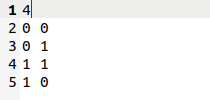

(Esto es sólo un ejemplo de respuesta, dado que para ficheros pequeños se aplica "Concorde").

La respuesta que se obtiene de esta petición tiene la siguiente forma:

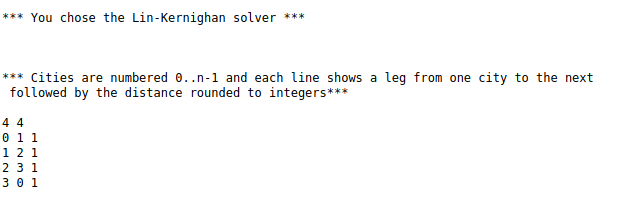 

Donde lo importante es la primera columna de valores, justo debajo del número de nodos. Así pues,
habrá que extraer esta información de la respuesta.

Una vez se ha enviado la petición "Post", será hora de obtener la respectiva respuesta utilizando el
comando "requests.get(url)". Si se ha obtenido una respuesta correcta, el formato del "HTML" recibido
tendrá la siguiente forma:

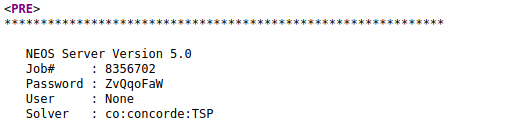

Donde obtendremos todo el contenido que esté dentro de la etiqueta "pre", para luego separarlo según 
los saltos de línea.

Como se puede apreciar en el formato de la respuesta, existe una línea que tiene la forma: "n_nodos n_nodos", 
y justo después, se encuentra el vector que queremos recuperar. Por tanto, una vez se ha particionado la
respuesta según los saltos de línea, se obtienen aquellos elementos que están después de este par de número 
de nodos (b.index(cutter)+1:-1). 

Iterando esta nueva sublista, se parte cada elemento por espacios, para finalmente, quedarse con el primer 
elemento de éstos, que corresponde con el número del nodo.

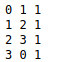

Es decir, cada una de estas líneas de divide por espacios [0, 1, 1], y se obtiene únicamente el primer elemento.

Finalmente se tiene un vector solución con todos los nodos recorridos, el cual se retorna.

In [ ]:
def getResult(nodeCount, url):
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")
    a = soup.findAll('pre')[0].text

    b = a.split('\n')
    cutter = str(nodeCount) + ' ' + str(nodeCount)

    tour = [int(i.split(' ')[0]) for i in b[b.index(cutter)+1:-1]]

    return tour

**ENVIANDO LA PETICIÓN**

La dirección URL a la que se envían las peticiones es la siguiente: https://neos-server.org/neos/cgi-bin/nph-neos-solver.cgi, 
al que se le envía como respuesta de un formulario, los siguientes campos, los cuales fueron extraídos del código fuente de esta página.

Los campos a enviar son:
1. field.4: Acepta los valores 'lk'->Lin-Kernighan, 'cqs'->Concorde(QSopt), 'con'->Concorde(CPLEX) ---> Escoge el resolutor.
2. field.5: Acepta los valores 'fixed'->99, 'variable'->random ---> Escoge la semilla.
3. field.6: Acepta los valores 'no'->No tour plot,'cp'->PDF of optima,'pf'->Without cities ---> Especifica como se desea la salida.

A partir de aquí, son campos automáticos a enviar, necesarios para que el servidor reconozca el tipo de problema. 
4. solver: Selecciona que se está trabajando sobre Concorde.
5. inputMethod: Selecciona que se está trabajando sobre TSP.
6. auto-fill: Autocompletado.
7. category: Concorde

Una vez completado el "formulario", se procede a enviarlo al servidor, adjuntado el fichero a resolver, en este caso usando el campo
"files" de la petición "Post", enviando el contenido de éste. Cabe destacar que en el formulario, el campo en el que se envía el fichero
tiene la clave "field.1", importante para que pueda ser reconocido por el servidor.

La respuesta que se obtiene de esta petición tiene la siguiente forma:

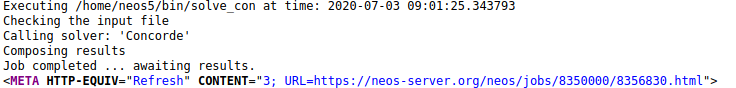

De esta respuesta se ha de extraer la "URL" que se muestra en la imagen, puesto que el resultado final se encuentra ahí, y será transferido
posteriormente al método "getResult()". Para ello, se procede a observar la respuesta "HTML", y se obtiene las etiqueta "meta" usando la 
herramienta "BeautifulSoup". Una vez obtenido este contenido, simplemente se busca la primera "L" de la respuesta, y se procede a cortar
a partir de la siguiente posición, hasta que se encuentre un espacio.

Con lo que se obtiene finalmente, la "URL" del resultado, que será devuelto al lugar desde el que se llamó.

In [ ]:
def getPost(path):
    url_send = 'https://neos-server.org/neos/cgi-bin/nph-neos-solver.cgi'
    info = {'field.4': 'lk',
            'field.5': 'fixed',
            'field.6': 'no',
            'solver': 'concorde',
            'inputMethod': 'TSP',
            'auto-fill': 'yes',
            'category': 'co',
            }

    response = requests.post(url_send, data=info, files={'field.1': ('reading', open(path, 'rb'))})

    soup = BeautifulSoup(response.content, "html.parser")
    a = str(soup.findAll('meta')[0])

    indI = a.find('L')+2
    indF = a.find(' ', indI)-1
    return a[indI:indF]

**DESCARGANDO EL RESOLUTOR CONCORDE**

A parte de ejecutar el resolutor "Concorde" instalado en el kernel, asi como "Link-kernighan" en el
servidor web, también se ejecutará usando los ejecutables "Concorde", y "Linkern" en bash.

Para ello se descarga ambos ejecutables de su página oficial, se crea un carpeta "Temp", ya que ambos
generarán los ficheros con la solución.

In [ ]:
%%bash
wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/linux24/concorde.gz
wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/linux24/linkern.gz
gunzip /kaggle/working/concorde.gz
gunzip /kaggle/working/linkern.gz
mkdir -p /kaggle/working/Temp
chmod u+x /kaggle/working/concorde
chmod u+x /kaggle/working/linkern

**EJECUTANDO LIN-KERNIGHAN**

Para ejecutar este script, se ha de pasar como parámetro  "-o" seguido del nombre del fichero
donde s almacenará el tour final, además de "-N" seguido de un 2, para ejecutar usando distancias
euclideanas, y finalmente la ruta del fichero.

Si durante la ejecución se obtuvo un error, entonces se devuelve True, para realizar el tratamiento
posterior, en la caso de que se haya obtenido una respuesta satisfactoria, se abre el fichero generado,
se lee su contenido, y se obtiene el tour en una lista a devolver.

El fichero resultado tiene el siguiente formato:

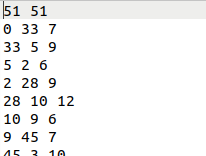

Donde la primera línea contiene un par del número de nodos, y el resto es el tour.

In [ ]:
def getLin(path, nam):
    run = "/kaggle/working/linkern -o " + nam + " -N 2 " + path
    process = subprocess.Popen(run.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    if error:
        print("Oh no! ERROR")
        return True, None
    
    sol = open(nam, "r")    
    b = sol.read().split('\n')

    tour = [int(i.split(' ')[0]) for i in b[1:-1]]
    
    return False, tour

**EJECUTANDO CONCORDE**

Al igual que el script "linkern", éste tiene el mismo funcionamiento, excepto que se añade
un nuevo parámetro a la orden del script, "-x", esto evita que se genere fichero temporales.

Este resolutor asegura óptimos, por tanto, tarda más tiempo, así que para controlarlo, se pone
un límite de 120 segundos, si se expira este tiempo, entonces se mata el proceso y se devuelve 
verdadero, afirmando que ha ocurrido un problema en la ejecución, al igual que, si se obtiene
una salida de error, también se devuelve un verdadero.

Si todo ha ido bien, debería haberse creado un fichero solución, tal y como con "linkern",
pero con un parsep distinto.

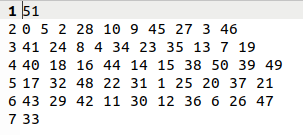

Finalmente se devuelve el tour y un falso, confirmando así que no hubo errores.

In [ ]:
def getConcorde(path, nam):    
    run = "/kaggle/working/concorde -x -o " + nam + " -N 2 " + path
    process = subprocess.Popen(run.split(), stdout=subprocess.PIPE)
    try:
        process.wait(timeout=120)
    except subprocess.TimeoutExpired:
        try:
            os.kill(process.pid, 0)
        finally:
            return True, None
    output, error = process.communicate()
    if error:
        print("Oh no! ERROR")
        return True, None
    
    sol = open(nam, "r")    
    b = sol.read().split("\n")
    tour = []
    for x in b[1:-1]:
        tour.extend(list(map(int, x.split())))
    
    return False, tour

**RESOLVIENDO EL PROBLEMA**

Haciendo pruebas con el resolutor del servidor web, nos percatamos que no es capaz de trabajar adecuadamente con decimales, por ello
se divide en dos los ficheros a tratar, atendiendo si alguna de las coordenadas tiene parte decimal o no.

Si se obtiene que el booleano "decimal" es verdadero, entonces el fichero será resuelto usando el resolutor "Concorde", que obtendrá
el óptimo de este fichero. Para emplear este resolutor, se transforma las coordenadas en una "data frame", y se aplica la distancia
euclideana, se pone un límite de 120 segundos por si se demore mucho timepo. De la respuesta de este método simplemente se obtiene
el tour en formato de lista "res.tour.tolist()".

Si el fichero no tiene decimales, entonces se calcula usando el ejecutable "Concorde" descargado, este ejecutable se lanza en bash,
por lo que se controlará su tiempo de ejecución, si se obtiene un error en sus ejecución, entonces se procede a usar "Lin-kernighan",
tanto en el servidor web, como con el ejecutable "linkern", y se obtiene la mejor solución, para poder usar los ejecutables, se ha de
pasar como parámetro a sus métodos un nombre fichero donde se almacenará el resultado final, además de la localización del fichero de 
datos a tratar.

Finalmente se añade la primera posición para dejarlo den el formato adecuado, y se comprueba si es correcta la solución.

In [ ]:
def solve_it(input_data, path):
    # Modify this code to run your optimization algorithm

    # parse the input
    lines = input_data.split('\n')

    nodeCount = int(lines[0])

    points = []
    decimal = False
    for i in range(1, nodeCount+1):
        line = lines[i]
        parts = line.split()
        a = float(parts[0])
        b = float(parts[1])
        points.append(Point(a, b))
        if not decimal and not (a.is_integer() and b.is_integer()):
            decimal = True

    # El solver de la página web no es capaz de trabajar con decimales,
    # por tanto, hemos separado en dos casos. Llamando en uno al solver
    # de dicha página web, o resolviéndolo con el solver instalado.
    if decimal:
        a = pd.DataFrame(points)

        solver = TSPSolver.from_data(a.x, a.y, norm="CEIL_2D")
        res = solver.solve(time_bound=120)

        solution = res.tour.tolist()
    else:
        name = "/kaggle/working/Temp/" + path[path.index("/", 23)+1:] + ".sol"
        errorB, solution = getConcorde(path, name)
                
        # Si no se ha podido obtener resultado usando Concorde (errorB=True), se procede a ejecutar "Lin-Kernighan",
        # tanto con el ejecutable "linkern" como con el servidor web, y se obtiene el mejor.
        if errorB:
            errorL, solutionL = getLin(path, name) # Si la ejecución de "linkern" ha fallado, se devuelve true.
        
            urlFile = getPost(path) # Se obtiene el resultado del servidor.
            solutionS = getResult(nodeCount, urlFile)
                                    
            if errorL: # Si se obtuvo un error ejecutando "linkern", entonces no hace falta compararlos.
                solution = solutionS                
            else:
                solutionL.append(solutionL[0])
                objL = check_solution(solutionL, points, nodeCount)
                
                solutionS.append(solutionS[0])
                objS = check_solution(solutionS, points, nodeCount)
                
                solution = solutionL if objL <= objS else solutionS # Se calcula el valor objetivo, y se coge el menor.
                        
    solution.append(solution[0])

    obj = check_solution(solution, points, nodeCount)

    # prepare the solution in the specified output format
    output_data = '%.2f' % obj + ' ' + str(0) + '\n'
    output_data += ' '.join(map(str, solution))

    return output_data, obj

In [ ]:
str_output = [["Filename", "Value"]]
counter = 0
for dirname, _, filenames in os.walk('/kaggle/input/input-data'):
    for filename in filenames:
        full_name = dirname+'/'+filename
        with open(full_name, 'r') as input_data_file:
            input_data = input_data_file.read()
            output, value = solve_it(input_data, full_name)
            str_output.append([filename,str(value)])
        counter += 1
        print(filename, "-->", value, "|| Progreso -> ", counter, "/76")
        print("-----------------------------------------------------------------------------------")
        
sortedlist = sorted(str_output, key=lambda row: row[0], reverse=False)
submission_generation('tsp_concorde.csv', sortedlist)

**RESULTADOS FINALES**

Los resultados finales obtenidos fueron:

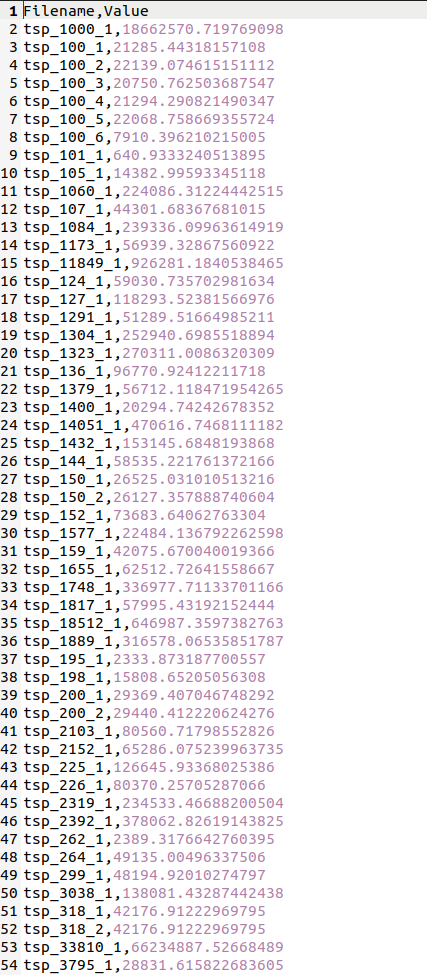
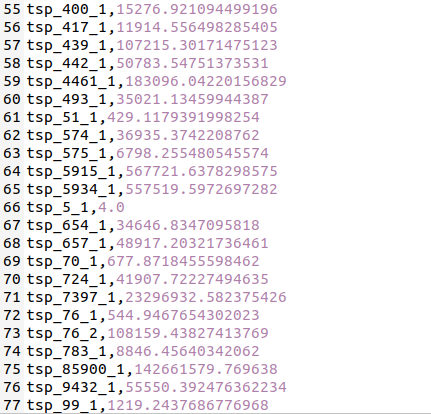